## A life-cycle consumption model with a discrete choice

- author: Tao Wang
- date: Mar 2024

- This notebook extends the basic life cycle class to solve an additional discrete choice problem using upper-envolope EGM

- We consider a simple example of a discrete choice: investment in the financial literacy.
  - besides consumption, the agent chooses to invest in their own financial literacy, by incurring a utility cost in the current perior for the benefit of a higher return in savings next period. 


- The code developed here significantly benefits from this tutorial [Notebook](https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb) and [Econ-ark](https://github.com/econ-ark).
- The main challenge of the computation for a continuous-discrete problem is that the possible discrete choices in future make the value function non-monotonic. This makes the FOC as in EGM methods only necessary but not sufficient condition for the optimal continuous choices. To put it differently, there might be multiple optiomal choices depending on different discrete choices at which FOCs hold.

In [1]:
import numpy as np
from interpolation import mlinterp
from numba import float64, int64, boolean
from numba.experimental import jitclass
import matplotlib.pyplot as plt
from time import time
from copy import copy 
from HARK.dcegm import calc_multiline_envelope, calc_prim_kink #calc_segments
from HARK.interpolation import calc_log_sum_choice_probs, LinearInterp



In [2]:
from resources_jit import MeanOneLogNormal as lognorm
from SolveLifeCycle import EGM_br

In [3]:
## plot configuration 

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

## The Model Class and Solver

In [4]:
lc_data = [
    ## model paras
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Real interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent state  x
    ('z_val', float64[:]),       # values of z, grid values for the continuous (macro) persistent state    x
    ('sigma_psi', float64),      # permanent shock volatility              x
    ('sigma_eps', float64),      # transitory shock volatility
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-permanent income
    ('b_y', float64),            # loading of macro state to income        x 
    ('borrowing_cstr',boolean),  ## artificial borrowing constraint if True, natural borrowing constraint if False
    ('U',float64),               # the i.i.d. probability of being unemployed    * 
    ('sigma_psi_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transitory risk, only 2 for now
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('sigma_p_init',float64),         ## standard deviation of initial income
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('LivPrb',float64[:]),         # the probability of being alive next period 
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('state_dependent_risk', boolean),     ## True if 2-state risks
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64),         ## zero: bequest thrown to the ocean; one: fully given to newborns
    ('theta',float64),           ## extrapolation parameter
    ## computational paras
    ('a_grid', float64[:]),      # Exogenous grid over savings
    ('eps_grid', float64[:]),    # Exogenous grid over transitory income shocks (for ma only)
    ('psi_shk_draws', float64[:]), ## draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # draws of MA/transitory income shocks 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('psi_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income
    ## regarding subjective beliefs
    ('P_sub',float64[:, :]),            # trans probs of belief states
    ('U2U_2mkv',float64[:]),            # state-dependent U2U prob
    ('E2E_2mkv',float64[:]),            # state-dependent E2E prob
    ('sigma_psi_true', float64),      # true permanent shock volatility              
    ('sigma_eps_true', float64),      # ture transitory shock volatility
    ('subjective',boolean),  ## belief is not necessarily equal to true 
    ('state_dependent_belief',boolean),  ## belief is state-dependent
    ('psi_shk_true_draws',float64[:]), ## draws of true permanent income shock 
    ('eps_shk_true_draws',float64[:]), ## draws of true transitory income shock 
    
    ## bequest motive 
    ('q',float64), ## q = 0 if no bequest motive 
    ('ρ_b',float64), ## elasticity of bequest 
    
    ### new value func
    ('value_func',boolean), ## boolean to decide if calculating value funcs 
    ### preference shock
    ('pref_shock',float64), ## = 0 if no preference shock, therefore 1 or 0 discrete choice; positive values means a smoothed log probs of discrete choices ]
]

In [5]:
@jitclass(lc_data)
class LifeCycleDC:
    """
    A class that stores primitives for a life-cycle consumption problem.
    """

    def __init__(self,
                 ρ = 1.0,     ## relative risk aversion  
                 β = 0.99,    ## discount factor
                 P = np.array([[0.9,0.1],
                              [0.2,0.8]]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,
                                   1.0]), ## markov state from low to high  
                 sigma_psi = 0.10,     ## size of permanent income shocks
                 sigma_eps = 0.10,   ## size of transitory income risks
                 x = 0.0,            ## MA(1) coefficient of non-permanent income shocks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 U = 0.0,   ## unemployment risk probability (0-1)
                 LivPrb = 0.995*np.ones(60),       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 R = 1.02,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65 (including 65)
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 7,
                 grid_max = 5.0,
                 grid_size = 50,
                 ## subjective state dependent 
                 subjective = False,
                 state_dependent_belief = False,
                 P_sub = np.array([[0.5,0.5],
                              [0.5,0.5]]), 
                 sigma_psi_2mkv = np.array([0.05,0.2]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.08,0.12]),  ## transitory risks in 2 markov states
                 U2U_2mkv = np.array([0.05,0.1]),         ## U2U in low and high risk mkv state
                 E2E_2mkv = np.array([0.95,0.9]),         ## E2E in low and high risk mkv state
                 theta = 2,               ## asymmetric extrapolation parameter
                 unemp_insurance = 0.0,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 state_dependent_risk = False,
                 adjust_prob = 1.0,
                 sigma_p_init = 0.01,
                 init_b = 0.0,
                 λ = 0.0,
                 λ_SS = 0.0,
                 transfer = 0.0,
                 bequest_ratio = 0.0,
                 sigma_psi_true = 0.10,     ## true size of permanent income shocks
                 sigma_eps_true = 0.10,     ## ture size of transitory income risks  
                 q = 0.0,     # no bequest by default
                 ρ_b = 1.0,
                 ####
                 value_func = False,
                 ####
                 pref_shock = 0.00
                ): 
        self.ρ, self.β = ρ, β
        #####################
        self.q, self.ρ_b = q,ρ_b 
        ######################
        self.R = R 
        self.W = W
        self.P, self.z_val = P, z_val
        self.U = U
        #assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.subjective = subjective 

        ###################################################
        ## fork depending on subjective or objective model ##
        #####################################################

        self.sigma_psi = sigma_psi
        self.sigma_eps = sigma_eps
            
        if self.subjective==False:
            self.sigma_psi_true = self.sigma_psi
            self.sigma_eps_true = self.sigma_eps
        else:
            print('reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!')
            self.sigma_psi_true = sigma_psi_true
            self.sigma_eps_true = sigma_eps_true
            
        self.x = x
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ_SS
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 
        self.sigma_psi_2mkv = sigma_psi_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        self.state_dependent_risk = state_dependent_risk
        
        ## belief 
        self.P_sub = P_sub
        self.state_dependent_belief = state_dependent_belief

            
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        self.prepare_shocks()
        
        ## saving a grid
        a_grid_regular = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size-1))
        self.a_grid = np.append(a_grid_regular,np.max(a_grid_regular)*100)
        
        ## ma(1) shock grid 
        if sigma_eps!=0.0 and x!=0.0:
            lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
            ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
            self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        else:
            self.eps_grid = np.array([0.0,0.001])  ## make two points for the c function to be saved correctly  

    
        ## extrapolation coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability (not needed if it is life-cycle)
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."  

        ############
        self.value_func = value_func
        ###########
        self.pref_shock = pref_shock
        ############################
        
    ## utility function 
    def u(self,c):
        if self.ρ!=1:
            return c**(1-self.ρ)/(1-self.ρ)
        elif self.ρ==1:
            return np.log(c)
        
    def u_inv(self,u):
        if self.ρ!=1:
            return (u*(1-self.ρ))**(1/(1-self.ρ))
        elif self.ρ==1:
            return np.exp(u)
    
    # marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)
    
    
    #########################
    ## transfer func for v func
    ######################
    
    def vTransf(self,v):
        # inverse transform v function after linear interporlation\n",
        return self.u_inv(v)
    
    def vUntransf(self,m):
        # inverse transform v function after linear interporlation\n",
        return self.u(m)
    
    ## a function for the transitory/persistent income component
    ### the fork depending on if discrete-markov bool is on/off
    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to income
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            ## ump if z ==0 and emp if z==1
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)
        
    # a function from the log permanent shock to the income factor
    def Γ(self,psi_shk):
        return np.exp(psi_shk)
    
    def prepare_shocks(self):
        subjective = self.subjective
        shock_draw_size = self.shock_draw_size
        sigma_psi = self.sigma_psi
        sigma_eps = self.sigma_eps
        sigma_psi_true = self.sigma_psi_true
        sigma_eps_true = self.sigma_eps_true
        sigma_p_init = self.sigma_p_init
        sigma_psi_2mkv = self.sigma_psi_2mkv
        sigma_eps_2mkv = self.sigma_eps_2mkv
        
        ##################################################################
         ## discretized distributions 
        ##################################################################
                
        psi_shk_dist = lognorm(sigma_psi,100000,shock_draw_size)
        self.psi_shk_draws = np.log(psi_shk_dist.X)  ## the discretized is lognormal variable itself, we work with the log of it
        eps_shk_dist = lognorm(sigma_eps,100000,shock_draw_size)
        self.eps_shk_draws = np.log(eps_shk_dist.X)
        
        ## the draws used for simulation in household block 
        if subjective==False:
            self.psi_shk_true_draws =  self.psi_shk_draws
            self.eps_shk_true_draws =  self.eps_shk_draws
        else:
            psi_shk_true_dist = lognorm(sigma_psi_true,100000,shock_draw_size)
            eps_shk_true_dist = lognorm(sigma_eps_true,100000,shock_draw_size)
            self.psi_shk_true_draws =  np.log(psi_shk_true_dist.X)
            self.eps_shk_true_draws =  np.log(eps_shk_true_dist.X)
            
        # 100000 is a magic number but it is big enough.
        init_p_dist = lognorm(sigma_p_init,100000,shock_draw_size)
        self.init_p_draws = np.log(init_p_dist.X)
        
        ## draw shocks for various markov state of volatility 
        #sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        sigma_psi_2mkv_l = lognorm(sigma_psi_2mkv[0],100000,shock_draw_size)
        sigma_psi_2mkv_h = lognorm(sigma_psi_2mkv[1],100000,shock_draw_size)
        
        self.psi_shk_mkv_draws = np.stack((np.log(sigma_psi_2mkv_l.X),
                                         np.log(sigma_psi_2mkv_h.X)))
        
        sigma_eps_2mkv_l = lognorm(sigma_eps_2mkv[0],100000,shock_draw_size)
        sigma_eps_2mkv_h = lognorm(sigma_eps_2mkv[1],100000,shock_draw_size)
        
        self.eps_shk_mkv_draws = np.stack((np.log(sigma_eps_2mkv_l.X),
                                         np.log(sigma_eps_2mkv_h.X)))
        
    def terminal_solution(self):
        
        ## depending on if bequest 
        
        k = len(self.a_grid)
        k2 =len(self.eps_grid)
        n = len(self.P)
        σ_init = np.empty((k,k2,n))
        m_init = np.empty((k,k2,n))
        ################################
        v_init = np.empty((k,k2,n))
        d_init = np.ones((k,k2,n))
        ###############################
        if self.q ==0.0:
            for z in range(n):
                for j in range(k2):
                    m_init[:,j,z] = self.a_grid
                    σ_init[:,j,z] = m_init[:,j,z]
                    if self.value_func:
                        v_init[:,j,z] = self.u(σ_init[:,j,z])
        else:
            for z in range(n):
                for j in range(k2):
                    σ_init[:,j,z] = (self.q*self.a_grid**(-self.ρ_b))**(-1/self.ρ)
                    m_init[:,j,z] = self.a_grid + σ_init[:,j,z]
                    if self.value_func:
                        v_init[:,j,z] = self.u(σ_init[:,j,z])+self.q*self.u(m_init[:,j,z]-σ_init[:,j,z])
        return m_init,σ_init,σ_init, d_init,v_init,v_init,v_init

## Still Under Development!!!

In [6]:
utility_cost = 0.13
higher_return = 1.12
pref_shock = 0.0001

In [7]:
## define a func that checks if grids are monotonic 
def is_monotonic(arr):
    return all(arr[i] <= arr[i + 1] for i in range(len(arr) - 1))

In [8]:
## This extends EGM_vfunc to incorporate upper envolope EGM for a hypothetic discrete choice 
#@njit
def EGM_DC(mϵ_in, ## grids 
           σ_1_in, ## the consumption policy of discrete choice 1
           σ_2_in, ## the consumption policy of discrete choice 2
           d_in,
           v_1_in, ## the value function of discrete choice 1
           v_2_in, ## the value function of discrete choice 2
           v_in,   ## the unconditional value function 
           age_id,
           lc):
    """
    The backward iterating operator for the life-cycle consumption problem,
    using the endogenous grid method with upper envelopes.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * mϵ_in is the same sized grid points of the three state variable 
        * mϵ_in[:,j,z] is the vector of wealth grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
        % v_1 and v_2 are values  
    """    
    # Simplify names
    u_func = lc.u
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    vTransf,vUntransf = lc.vTransf,lc.vUntransf
    ρ, β = lc.ρ, lc.β
    R = lc.R

    ## markov state
    P = lc.P
    W = lc.W
    z_val = lc.z_val
    a_grid,eps_grid = lc.a_grid,lc.eps_grid
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws
    psi_shk_mkv_draws, eps_shk_mkv_draws = lc.psi_shk_mkv_draws, lc.eps_shk_mkv_draws
    borrowing_cstr = lc.borrowing_cstr 
    ue_prob = lc.U  ## uemp prob
    unemp_insurance = lc.unemp_insurance
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability
    #adjust_cost = lc.adjust_cost  ## adjustment cost of consumption 
    Y = lc.Y
    ####################
    Γ = lc.Γ
    ####################################
    G = lc.G[age_id+1]  ## get the age specific growth rate, G[T] is the sudden drop in retirement from working age
    LivProb = lc.LivPrb[age_id+1]  ## live probabilities
    ####################################
    
    #################################################
    ## get the expected marginal utility scalor
    E_psi_rho = np.mean((G/Γ(psi_shk_draws))**(-ρ))
     #################################################
        
    x = lc.x
    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    pension = lc.pension
    ###################

    n = len(P)
    
    # Create consumption functions by linear interpolation
    ########################################################
    σ_1 = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],eps_grid),σ_1_in[:,:,z], (m,ϵ)) 
    σ_2 = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],eps_grid),σ_2_in[:,:,z], (m,ϵ)) 
    d = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],eps_grid),d_in[:,:,z], (m,ϵ))

    #########################################################
    ## Create value functions by two-step interpolation 
    #########################################################
    ## (interpolate over transfored value function and inverse the transformation)
    
    if lc.value_func:
        v_1_Tfunc_in = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],
                                             eps_grid),
                                            vTransf(v_1_in[:,:,z]), 
                                            (m,ϵ)) 
        v_1_func_in  = lambda m,ϵ,z: vUntransf(v_1_Tfunc_in(m,ϵ,z))
        
        v_2_Tfunc_in = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],
                                             eps_grid),
                                            vTransf(v_2_in[:,:,z]), 
                                            (m,ϵ)) 
        v_2_func_in  = lambda m,ϵ,z: vUntransf(v_2_Tfunc_in(m,ϵ,z))

        v_Tfunc_in = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],
                                             eps_grid),
                                            vTransf(v_in[:,:,z]), 
                                            (m,ϵ)) 
        v_func_in  = lambda m,ϵ,z: vUntransf(v_Tfunc_in(m,ϵ,z))
    
    # Allocate memory
    σ_1_out = np.empty_like(σ_1_in)  ## grid_size_s X grid_size_ϵ X grid_size_z
    σ_2_out = np.empty_like(σ_2_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    d_out = np.empty_like(d_in)   
    
    v_1_out = np.empty_like(v_1_in)
    v_2_out = np.empty_like(v_2_in)
    
    ############################################################################
    ## repeat the following chunk for each discrete choice: adjust versus non-adjust
    ### the policy next period will be useful to compute marginal utilities 
    ##########################################################################
    
    ## for the choice=1 people, c is determined by foc as before
    # Obtain c_i at each a_i, z, store in σ_out[i, z], computing
    # the expectation term by computed by averaging over discretized equally probable points of the distributions
    for i, a in enumerate(a_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                Ev = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ########################################
                    if lc.state_dependent_risk == False:
                        pass
                    else:
                        psi_shk_draws = psi_shk_mkv_draws[z_hat,:]
                        eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                    ########################################
                    for eps_shk in eps_shk_draws:
                        for psi_shk in psi_shk_draws:
                            ## for employed next period 
                            Γ_hat = Γ(psi_shk) 
                            u_shk = x*eps+eps_shk
                            age = age_id + 1
                            if age <=lc.T-1:   #till say 39, because consumption policy for t=40 changes   
                                ## work 
                                Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed
                                c_hat_1 = σ_1(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)
                                c_hat_2 = σ_2(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)

                                ## a little section of the code that gets the cloest m over the grid
                                m_grid = mϵ_in[:,0,z_hat]
                                m_grid_exd =  np.concatenate(([m_grid[0]-1], m_grid, [m_grid[-1]+1]))
                                m_cloest = max(0,min(np.digitize(R/(G*Γ_hat) * a + Y_hat+transfer,m_grid_exd)-1,len(m_grid)-1))

                                d_hat = d_in[m_cloest,0,z_hat]
                                c_hat = d_hat*c_hat_1+(1-d_hat)*c_hat_2
                                    
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                value = v_func_in(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_1_u = σ_1(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                c_hat_2_u = σ_2(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)

                                ## a little section of the code that gets the cloest m over the grid
                                m_grid = mϵ_in[:,0,z_hat]

                                #m_grid_exd =  np.concatenate(([m_grid[0]-1], m_grid, [m_grid[-1]+1]))
                                #m_cloest = max(0,min(np.digitize(R/(G*Γ_hat) * a + Y_hat_u+transfer,m_grid_exd)-1,len(m_grid)-1))
                                #d_hat_u= d_in[m_cloest,0,z_hat]
                                ##########################################
                                d_hat_u = d(R/(G*Γ_hat) * a + Y_hat_u+transfer,0.0,z_hat)
                                #########################################
                                c_hat_u = d_hat_u*c_hat_1_u+(1-d_hat_u)*c_hat_2_u

                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                            
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                           ue_prob*utility_u* P[z, z_hat]
                                          )
                                v_hat_1_u = v_1_func_in(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                v_hat_2_u = v_2_func_in(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                value_u = d_hat_u*v_hat_1_u+(1-d_hat_u)*v_hat_2_u
                                #value_u = v_func_in(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                                                
                                Ev += LivProb*((1-ue_prob)*value * P[z, z_hat]+
                                           ue_prob*value_u* P[z, z_hat]
                                          )
                            else:
                                ## retirement
                                Y_R = pension
                                ## no income shocks affecting individuals
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat_1_R = σ_1(R/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                c_hat_2_R = σ_2(R/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)

                                ## a little section of the code that gets the cloest m over the grid
                                #m_grid = mϵ_in[:,0,z_hat]
                                #m_grid_exd =  np.concatenate(([m_grid[0]-1], m_grid, [m_grid[-1]+1]))
                                #m_cloest = max(0,min(np.digitize(R/(G*Γ_hat) * a + Y_R+transfer,m_grid_exd)-1,len(m_grid)-1))
                                #d_hat_R = d_in[m_cloest,0,z_hat]
                                ################################################
                                d_hat_R = d(R/(G*Γ_hat) * a + Y_R+transfer,0.0,z_hat)
                                ###############################################
                                c_hat_R = d_hat_R*c_hat_1_R+(1-d_hat_R)*c_hat_2_R
                                                                    
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_R)
                                Ez += LivProb*utility * P[z, z_hat]
                                ##############################
                                v_hat_1_R = v_1_func_in(R/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                v_hat_2_R = v_2_func_in(R/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                value_R = d_hat_R*v_hat_1_R+(1-d_hat_R)*v_hat_2_R
                                #value_R = v_func_in(R/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)

                                Ev += LivProb*value_R* P[z, z_hat]
                            
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                Ev = Ev / (len(psi_shk_draws)*len(eps_shk_draws))

                ## the last step depends on if adjustment is fully flexible
                ## the two cases can collapse into one formula, but I keep them separately.
                if adjust_prob ==1.0:
                    σ_1_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <1.0:
                    σ_1_out[i, j, z] =  u_prime_inv(β * R*adjust_prob/(1-β*R*(1-adjust_prob))* Ez)
                    ## need to check if LivProb should be in the denominator
                    
                ## value func 
                v_1_out[i,j,z] = u_func(σ_1_out[i, j, z])+β*LivProb*Ev
                
  
    # Calculate endogenous asset grid
    mϵ_1_out = np.empty_like(σ_1_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            mϵ_1_out[:,j,z] = a_grid + σ_1_out[:,j,z]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            v_1_out[0,j,z] = -1e+10
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_1_out[0,j,z] = 0.0
                mϵ_1_out[0,j,z] = 0.0
            else:
                if age <=lc.T-1:
                    σ_1_out[0,j,z] = 0.0
                    ## the lowest transitory draw at state z  
                    if lc.state_dependent_belief:
                        self_min_a = - np.exp(np.min(eps_shk_mkv_draws[z,:]))*G/R 
                    else:
                        self_min_a = - np.exp(np.min(eps_shk_draws))*G/R

                    self_min_a = max(self_min_a,-unemp_insurance/R)
                    mϵ_1_out[0,j,z] = self_min_a
                else:
                    σ_1_out[0,j,z] = 0.0
                    self_min_a = - pension*G/R
                    mϵ_1_out[0,j,z] = self_min_a
                    

     ## for the choice=2 people
    
    R_high = R*higher_return ## R_high is the factor of benefit of financial literacy investment
    for i, a in enumerate(a_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                Ev = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ########################################
                    if lc.state_dependent_risk == False:
                        pass
                    else:
                        psi_shk_draws = psi_shk_mkv_draws[z_hat,:]
                        eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                    ########################################
                    for eps_shk in eps_shk_draws:
                        for psi_shk in psi_shk_draws:
                            ## for employed next period 
                            Γ_hat = Γ(psi_shk) 
                            u_shk = x*eps+eps_shk
                            age = age_id + 1
                            if age <=lc.T-1:   #till say 39, because consumption policy for t=40 changes   
                                ## work 
                                Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed
                                c_hat_1 = σ_1(R_high/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)
                                c_hat_2 = σ_2(R_high/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)
                                #######################################################
                                ## a little section of the code that gets the cloest m over the grid
                                #m_grid = mϵ_in[:,0,z_hat]
                                #m_grid_exd =  np.concatenate(([m_grid[0]-1], m_grid, [m_grid[-1]+1]))
                                #m_cloest = max(0,min(np.digitize(R_high/(G*Γ_hat) * a + Y_hat+transfer,m_grid_exd)-1,len(m_grid)-1))
                                #d_hat = d_in[m_cloest,0,z_hat]
                                ###############################################
                                d_hat = d(R_high/(G*Γ_hat) * a + Y_hat+transfer,0.0,z_hat)
                                ################################################
                                c_hat = d_hat*c_hat_1+(1-d_hat)*c_hat_2
                                    
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                value = v_func_in(R_high/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_1_u = σ_1(R_high/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                c_hat_2_u = σ_2(R_high/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                m_grid = mϵ_in[:,0,z_hat]
                                m_grid_exd =  np.concatenate(([m_grid[0]-1], m_grid, [m_grid[-1]+1]))
                                m_cloest = max(0,min(np.digitize(R_high/(G*Γ_hat) * a + Y_hat_u+transfer,m_grid_exd)-1,len(m_grid)-1))
                                d_hat_u = d_in[m_cloest,0,z_hat]==1
                                c_hat_u = d_hat_u*c_hat_1_u+(1-d_hat_u)*c_hat_2_u

                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                            
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                           ue_prob*utility_u* P[z, z_hat]
                                          )
                                v_hat_1_u = v_1_func_in(R_high/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                v_hat_2_u = v_2_func_in(R_high/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                value_u = d_hat_u*v_hat_1_u+(1-d_hat_u)*v_hat_2_u
                               #value_u = v_func_in(R_high/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                
                                Ev += LivProb*((1-ue_prob)*value * P[z, z_hat]+
                                           ue_prob*value_u* P[z, z_hat]
                                          )
                            else:
                                ## retirement
                                Y_R = pension
                                ## no income shocks affecting individuals
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat_1_R = σ_1(R_high/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                c_hat_2_R = σ_2(R_high/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                
                                ## a little section of the code that gets the cloest m over the grid
                                #m_grid = mϵ_in[:,0,z_hat]
                                #m_grid_exd =  np.concatenate(([m_grid[0]-1], m_grid, [m_grid[-1]+1]))
                                #m_cloest = max(0,min(np.digitize(R_high/(G*Γ_hat) * a + Y_R+transfer,m_grid_exd)-1,len(m_grid)-1))
                                #d_hat_R = d_in[m_cloest,0,z_hat]
                                 #################
                                d_hat_R = d(R_high/(G*Γ_hat) * a + Y_R+transfer,0.0,z_hat)
                                  #################
                                c_hat_R = d_hat_R*c_hat_1_R+(1-d_hat_R)*c_hat_2_R
                                                                    
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_R)
                                Ez += LivProb*utility * P[z, z_hat]
                                v_hat_1_R = v_1_func_in(R_high/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                v_hat_2_R = v_2_func_in(R_high/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                value_R = d_hat_R*v_hat_1_R+(1-d_hat_R)*v_hat_2_R
                                #value_R = v_func_in(R_high/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                Ev += LivProb*value_R* P[z, z_hat]
                            
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                Ev = Ev / (len(psi_shk_draws)*len(eps_shk_draws))

                ## the last step depends on if adjustment is fully flexible
                ## the two cases can collapse into one formula, but I keep them separately.
                if adjust_prob ==1.0:
                    σ_2_out[i, j, z] =  u_prime_inv(β * R_high* Ez)
                elif adjust_prob <1.0:
                    σ_2_out[i, j, z] =  u_prime_inv(β * R_high*adjust_prob/(1-β*R_high*(1-adjust_prob))* Ez)
                    ## need to check if LivProb should be in the denominator
                    
                ## value func 
                v_2_out[i,j,z] = u_func(σ_2_out[i, j, z])-utility_cost+β*LivProb*Ev
                
    # Calculate endogenous asset grid
    mϵ_2_out = np.empty_like(σ_2_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            mϵ_2_out[:,j,z] = a_grid + σ_2_out[:,j,z]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            v_2_out[0,j,z] = -1e+10
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_2_out[0,j,z] = 0.0
                mϵ_2_out[0,j,z] = 0.0
            else:
                if age <=lc.T-1:
                    σ_2_out[0,j,z] = 0.0
                    ## the lowest transitory draw at state z  
                    if lc.state_dependent_belief:
                        self_min_a = - np.exp(np.min(eps_shk_mkv_draws[z,:]))*G/R 
                    else:
                        self_min_a = - np.exp(np.min(eps_shk_draws))*G/R

                    self_min_a = max(self_min_a,-unemp_insurance/R)
                    mϵ_2_out[0,j,z] = self_min_a
                else:
                    σ_2_out[0,j,z] = 0.0
                    self_min_a = - pension*G/R
                    mϵ_2_out[0,j,z] = self_min_a
  

    #######################################
    ### Upper Envelope EGM  ###############
    ######################################
     ## now the EGM grid might not be monotonic any more 
     ## we need to use upper envelope EGM to get the increasing grid when this happens 
    
    ## for choice 1
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if not is_monotonic(mϵ_1_out[:,j,z]):
                #rise, fall = calc_segments(mϵ_1_out[:,j,z], 
                #                           v_1_out[:,j,z])
                mGrid = np.sort(mϵ_1_out[:,j,z])
                vT_1_out = vTransf(v_1_out[:,j,z])
                mGrid1_up, cGrid1_up, vTGrid1_up, xings = calc_multiline_envelope(mϵ_1_out[:,j,z], 
                                                                                    σ_1_out[:,j,z] ,
                                                                                    vT_1_out, 
                                                                                    mGrid,
                                                                                    find_crossings = False)
                
                if len(mϵ_1_out[:,j,z])!=len(mGrid1_up):
                    print('not equal length')
                    mϵ_1_out[:,j,z] = mGrid1_up[:len(mϵ_1_out[:,j,z])]
                    σ_1_out[:,j,z] = cGrid1_up[:len(mϵ_1_out[:,j,z])]
                    v_1_out[:,j,z] = vUntransf(vTGrid1_up[:len(mϵ_1_out[:,j,z])])
                else:
                    mϵ_1_out[:,j,z] = mGrid1_up
                    σ_1_out[:,j,z] = cGrid1_up
                    v_1_out[:,j,z] = vUntransf(vTGrid1_up)
                

    ## for choice 2
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if not is_monotonic(mϵ_2_out[:,j,z]):
              
                mGrid = np.sort(mϵ_2_out[:,j,z])
                vT_2_out = vTransf(v_1_out[:,j,z])
                mGrid2_up, cGrid2_up, vTGrid2_up, xings = calc_multiline_envelope(mϵ_2_out[:,j,z], 
                                                                                    σ_2_out[:,j,z] ,
                                                                                    vT_2_out, 
                                                                                    mGrid,
                                                                                    find_crossings = False)
                
                if len(mϵ_2_out[:,j,z])!=len(mGrid2_up):
                    mϵ_2_out[:,j,z] = mGrid1_up[:len(mϵ_2_out[:,j,z])]
                    σ_2_out[:,j,z] = cGrid1_up[:len(mϵ_2_out[:,j,z])]
                    v_2_out[:,j,z] = vUntransf(vTGrid2_up[:len(mϵ_2_out[:,j,z])])
                else:
                    mϵ_2_out[:,j,z] = mGrid2_up
                    σ_2_out[:,j,z] = cGrid2_up
                    v_2_out[:,j,z] = vUntransf(vTGrid2_up)
                    
    ##############################################
    ### need to recast 2 and v2 to v1's grid 
    ##############################################
    #### get interpolated c and v func for choice 2
                    
    σ_2_func_out = lambda m,ϵ,z: mlinterp((mϵ_2_out[:,0,z],eps_grid),σ_2_out[:,:,z], (m,ϵ)) 
    if lc.value_func:
        v_2_tfunc_out = lambda m,ϵ,z: mlinterp((mϵ_2_out[:,0,z],
                                             eps_grid),
                                            vTransf(v_2_out[:,:,z]), 
                                            (m,ϵ)) 
        v_2_func_out  = lambda m,ϵ,z: vUntransf(v_2_tfunc_out(m,ϵ,z))
    ## notice here we use mϵ_1_out grid, because we want to recast v2 to v1's grid 
    for i,m in enumerate(mϵ_1_out[:,0,0]):
        for j,ϵ in enumerate(eps_grid):
            for z in range(n):
                 v_2_out[i,j,z] = v_2_func_out(m,ϵ,z)
                 σ_2_out[i,j,z] = σ_2_func_out(m,ϵ,z)

    ## using choice 1's grid for both choices 
    mϵ_out = mϵ_1_out

    ##############################################################   
    ### calc_log_sum_choice_probs is used here 
    ##############################################################
    ## then need to calculate v_out 
    ############################################################
    vT_out = np.empty_like(v_1_out)
    ## overwriting d_out here 
    d_out = np.empty_like(d_in)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n): 
            ## calc_log_sum_choice_probs generates choice probabilities with the number of rows corresponding to discrete choices
            vT_out[:,j,z], d_out_2d = calc_log_sum_choice_probs(np.stack((vTransf(v_1_out[:,j,z]),
                                                                            vTransf(v_2_out[:,j,z]))),
                                                                    sigma = lc.pref_shock)
            d_out[:,j,z] = d_out_2d[0,:] ## 1 when the first choice is chosen
            # Now find the primary kink point (the point at which the optimal discrete decision changes)
            if lc.pref_shock == 0.0:
                pKink, segments = calc_prim_kink(mϵ_out[:,j,z], 
                                                 np.stack((vTransf(v_1_out[:,j,z]),
                                                           vTransf(v_2_out[:,j,z]))),
                                                 d_out_2d)
                if len(pKink) != 0:
                    m_kink = np.array([x[0] for x in pKink])
                    v_kink = np.array([x[1] for x in pKink])
                    # Insert the kink point into the value function grid and create the function.
                    idx = np.searchsorted(mϵ_out[:,j,z], m_kink)
                    print(idx)
                    ## remove the points before the newly added points 
                    removal_indices = idx-1
                    removal_indices[removal_indices < 0] = 0 
                    ## because the dimension changes due to inserted kink grids, need to keep the dimension 
                    m_temp = np.delete(mϵ_out[:,j,z], removal_indices)
                    idx_new = np.searchsorted(m_temp, m_kink)
                    m_temp = np.insert(m_temp, idx_new, m_kink)
                    mϵ_out[:,j,z] = m_temp

                    vT_out_temp = np.delete(vT_out[:,j,z],removal_indices)
                    vT_out[:,j,z] = np.insert(vT_out_temp, idx_new, v_kink)      
                    ## need to do the same for d_out!!!!
                    #d_out_temp = np.delete(d_out[:,j,z],removal_indices)
                    #d_out[:,j,z] = np.insert(d_out_temp, idx_new, 1.0)

    v_out = vUntransf(vT_out)
    v_out[0,:,:] = -1e+10
    return mϵ_out, σ_1_out,σ_2_out, d_out, v_1_out,v_2_out,v_out
    


In [9]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter_DC(model,        # Class with model information
                              mϵ_vec,         # Initial condition for assets and MA shocks
                              σ_1_vec,        # Initial condition for consumption
                              σ_2_vec,        # Initial condition for consumption
                              d_vec,
                              v_1_vec,
                              v_2_vec,
                              v_vec,
                              br = False):

    ## memories for life-cycle solutions 
    n_grids1 = σ_1_vec.shape[0]
    n_grids2 = σ_1_vec.shape[1]
    n_z = len(model.P)                       
    mϵs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    
    σs_1_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    σs_2_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    vs_1_new = np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    vs_2_new = np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    vs_new = np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    ds_new = np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)

    mϵs_new[0,:,:,:] = mϵ_vec
    σs_1_new[0,:,:,:] = σ_1_vec
    σs_2_new[0,:,:,:] = σ_2_vec
    ds_new[0,:,:,:] = d_vec
    vs_1_new[0,:,:,:] = v_1_vec
    vs_2_new[0,:,:,:] = v_2_vec
    vs_new[0,:,:,:] = v_vec
        
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        print("at work age of "+str(age))
        ## break the line below into separate lines 
        mϵ_vec_next = mϵs_new[year2L-1,:,:,:]
        σ_1_vec_next = σs_1_new[year2L-1,:,:,:]
        σ_2_vec_next =σs_2_new[year2L-1,:,:,:]
        d_vec_next = ds_new[year2L-1,:,:,:]
        v_1_vec_next =vs_1_new[year2L-1,:,:,:]
        v_2_vec_next =vs_2_new[year2L-1,:,:,:]
        v_vec_next = vs_new[year2L-1,:,:,:]

        if br==False:
            mϵ_new, σ_1_new,σ_2_new,d_new,v_1_new,v_2_new,v_new = EGM_DC(mϵ_vec_next, 
                                                                         σ_1_vec_next, 
                                                                         σ_2_vec_next,
                                                                         d_vec_next, 
                                                                         v_1_vec_next, 
                                                                         v_2_vec_next, 
                                                                         v_vec_next,
                                                                         age_id, 
                                                                         model)
        elif br==True:
            print('not yet developed for DC')
            #print('subjective model with stochastic risk')
            mϵ_new, σ_new = EGM_br(mϵ_vec_next, σ_vec_next, age_id, model)
        
        #print(np.isclose(σ_1_new, σ_2_new, rtol=1e-03, atol=1e-03).all())
        ## add back the list     
        mϵs_new[year2L,:,:,:] = mϵ_new
        σs_1_new[year2L,:,:,:] = σ_1_new
        σs_2_new[year2L,:,:,:] = σ_2_new
        ds_new[year2L,:,:,:] = d_new
        vs_1_new[year2L,:,:,:] = v_1_new
        vs_2_new[year2L,:,:,:] = v_2_new
        vs_new[year2L,:,:,:] = v_new
    return mϵs_new, σs_1_new,σs_2_new,ds_new,vs_1_new,vs_2_new,vs_new

In [10]:
## for infinite horizon problem 
def solve_model_iter_DC(model,       # Class with model information
                     me_vec,        # Initial condition for assets and MA shocks
                     σ_1_vec,       
                     σ_2_vec,       
                     d_vec,
                     v_1_vec,
                     v_2_vec,
                     v_vec,
                      tol=1e-6,
                      max_iter=2000,
                      verbose=True,
                      print_skip=50,
                      br = False):

    # Set up loop
    i = 0
    error = tol + 1
    stay = False

    ## memories for life-cycle solutions
    while i < max_iter and error > tol and stay==False:
        if br==False:
                me_new, σ_1_new,σ_2_new,d_new,v_1_new,v_2_new,v_new = EGM_DC(me_vec, 
                                                                             σ_1_vec,
                                                                             σ_2_vec,
                                                                             d_vec,
                                                                             v_1_vec,
                                                                             v_2_vec,
                                                                             v_vec,
                                                                             0,
                                                                             model)
        elif br==True:
            #print('subjective model with stochastic risk')
            print('Not developed yet for DC')
            mϵ_new, σ_new = EGM_br(me_vec, σ_vec, 0, model)

        error = np.maximum(np.max(np.abs(σ_1_vec - σ_1_new)),np.max(np.abs(σ_2_vec - σ_2_new)))
        stay = np.array_equal(d_new, d_vec)
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        me_vec, σ_1_vec,σ_2_vec,d_vec,v_1_vec,v_2_vec,v_vec = np.copy(me_new), np.copy(σ_1_new),np.copy(σ_2_new), np.copy(d_new), np.copy(v_1_new),np.copy(v_2_new),np.copy(v_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return me_vec, σ_1_vec,σ_2_vec,d_vec,v_1_vec,v_2_vec,v_vec

## Initialize the model

In [11]:
if __name__ == "__main__":

    ## parameters 
    ###################

    U = 0.2 ## transitory ue risk

    ## life cycle 

    T = 10
    L = 20
    G = np.ones(L)
    YPath = np.cumprod(G)

## Life-Cycle Problem 

In [12]:
## set the grid size 

grid_size = 200
grid_max = 9.0

In [13]:
if __name__ == "__main__":
    lc_paras = {'sigma_psi':0.15, # permanent 
                'sigma_eps': 0.1, #transitory
                'U':U,
                'ρ':2,
                'R':1.01,
                'T':T,
                'L':L,
                'G':G,
                'β':0.97,
                'x':0.0,  # no MA shock 
                'borrowing_cstr':True,
                'b_y':0.0, #no persistent state
                'unemp_insurance':0.15,
                'value_func': True,
                'grid_size': grid_size,
                'grid_max':grid_max,
                'pref_shock':pref_shock
               }

In [14]:
if __name__ == "__main__":
    lc_dc = LifeCycleDC(**lc_paras)

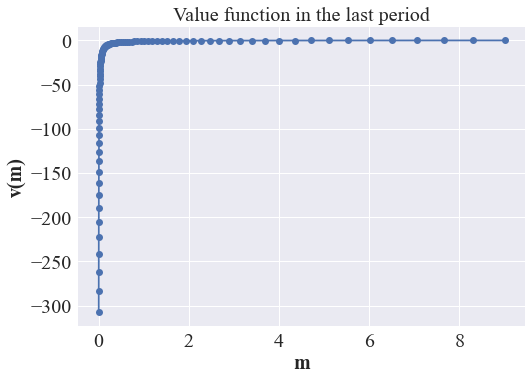

In [15]:
# Initial the end-of-period consumption policy of σ = consume all assets

if __name__ == "__main__":

    ## initial consumption functions 
    
    m_init,σ_1_init,σ_2_init,d_init,v_1_init,v_2_init,v_init = lc_dc.terminal_solution()
    plt.title('Value function in the last period')
    plt.plot(m_init[int(m_init.shape[0]/2):-1,1,1],
             v_1_init[int(m_init.shape[0]/2):-1,1,1],
            'o-')
    plt.xlabel('m')
    plt.ylabel('v(m)')

In [16]:
if __name__ == "__main__":

    t_start = time()

    ### this line is very important!!!!
    #### need to regenerate shock draws for new sigmas
    lc_dc.prepare_shocks()

    ## terminal solution
    m_init,σ_1_init,σ_2_init,d_init,v_1_init,v_2_init, v_init= lc_dc.terminal_solution()
    
    m_out,σ_1_out,σ_2_out,d_out,v_1_out,v_2_out,v_out = EGM_DC(m_init,
                                                               σ_1_init,
                                                               σ_2_init,
                                                               d_init,
                                                               v_1_init,
                                                               v_2_init,
                                                               v_init,
                                                               lc_dc.L-3, 
                                                               lc_dc)
        
    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 8.131219863891602


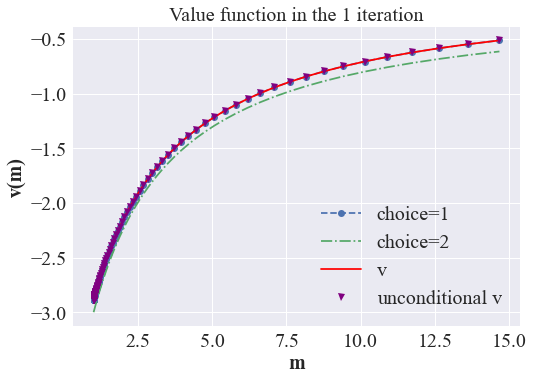

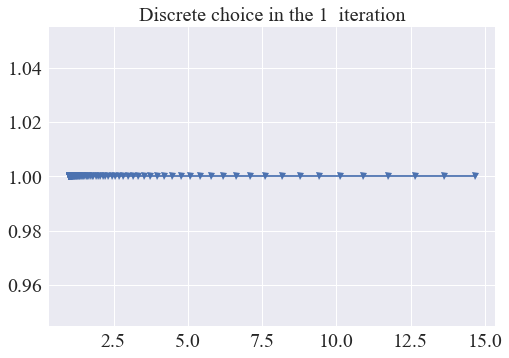

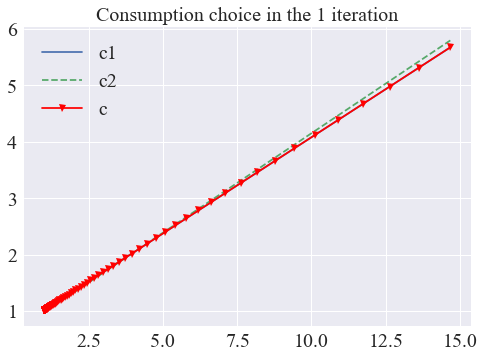

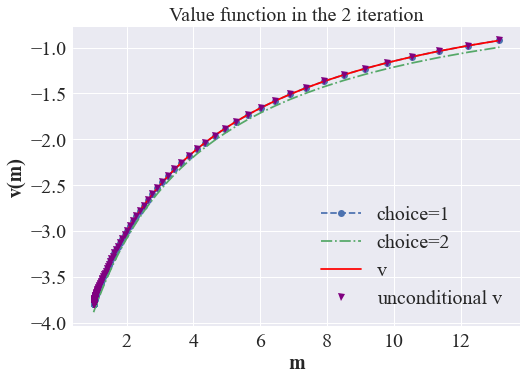

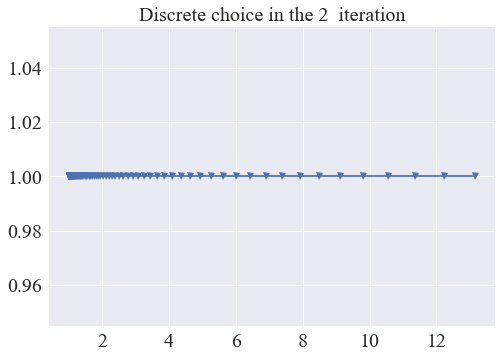

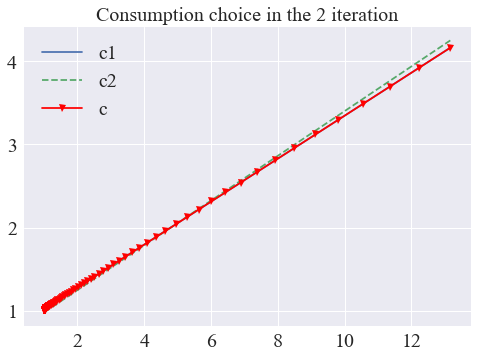

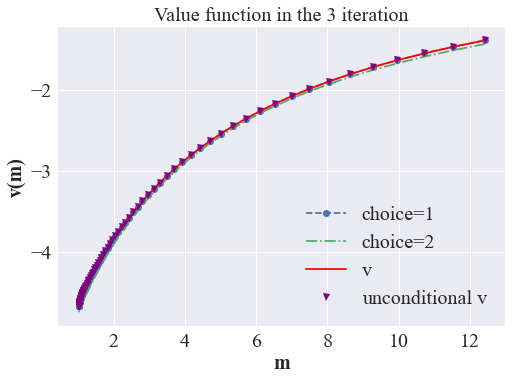

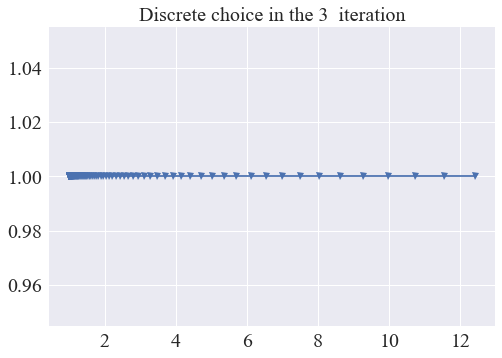

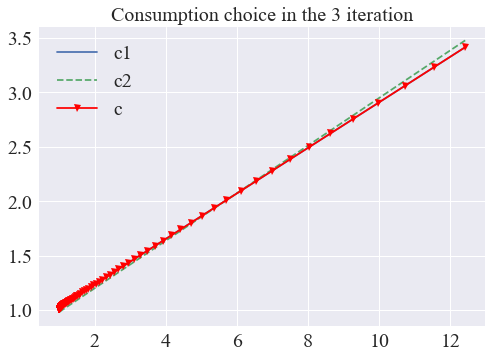

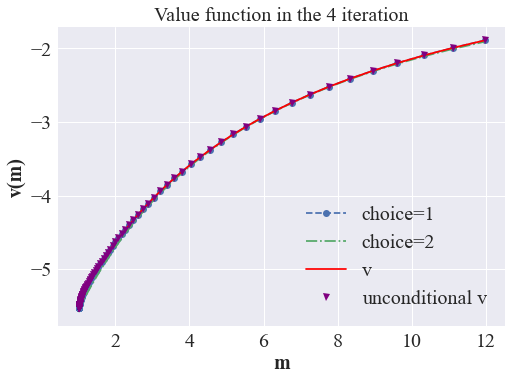

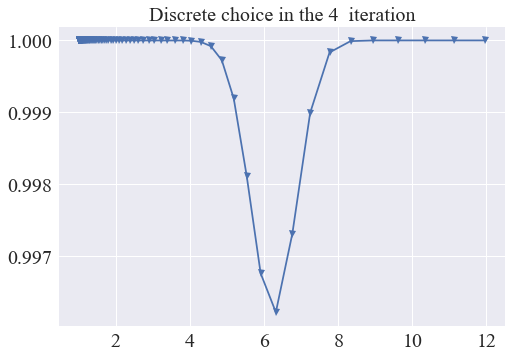

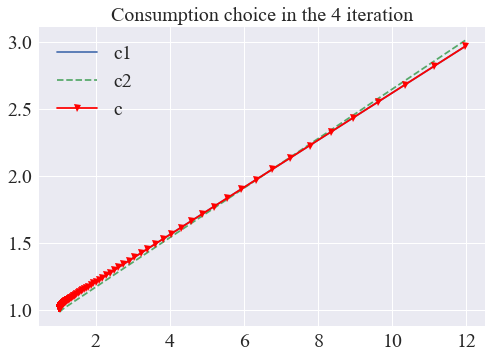

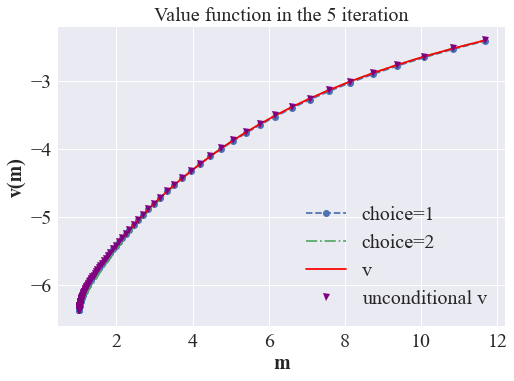

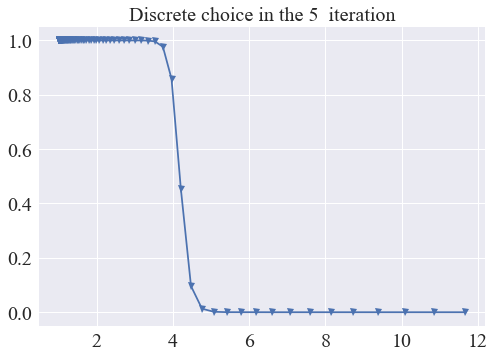

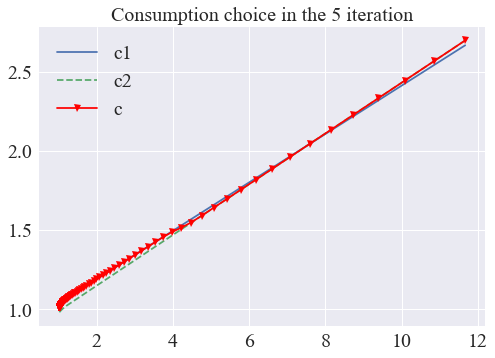

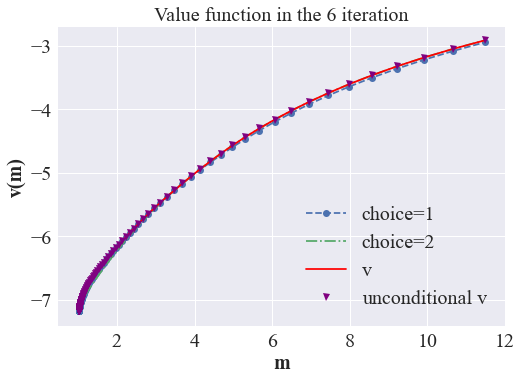

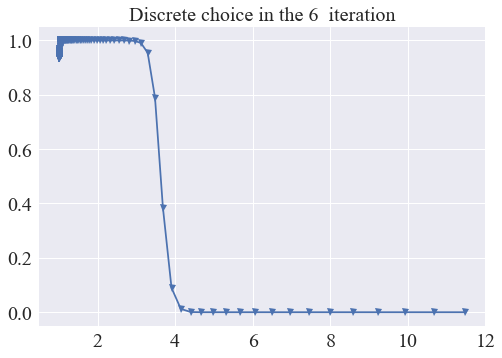

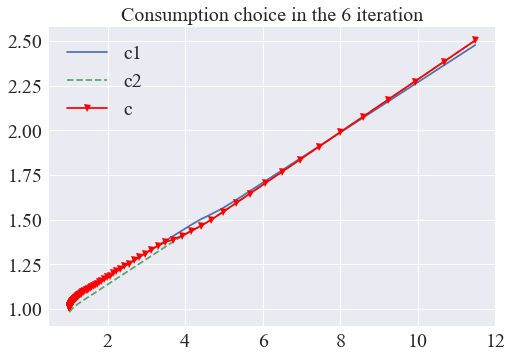

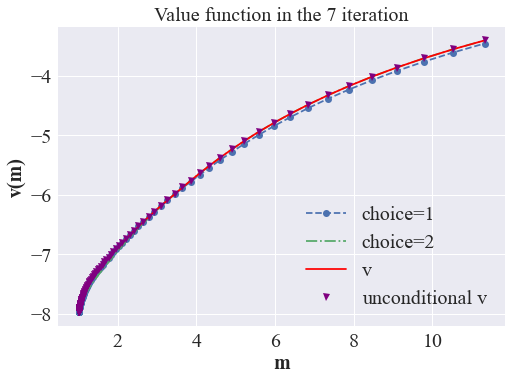

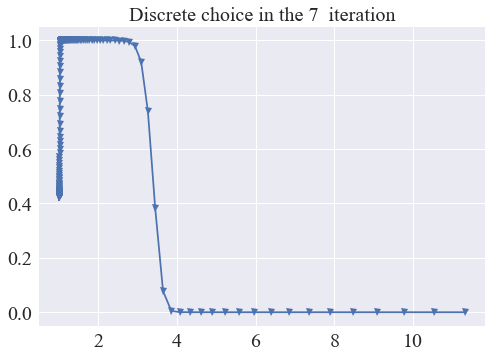

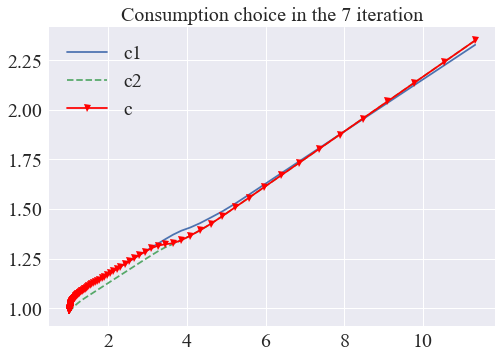

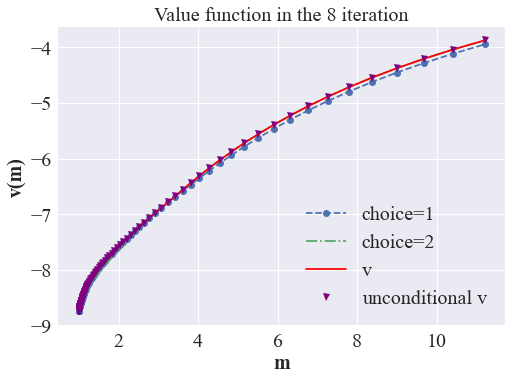

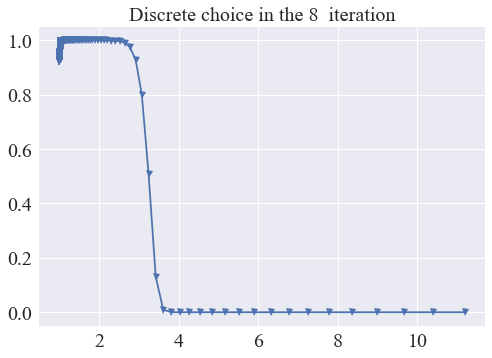

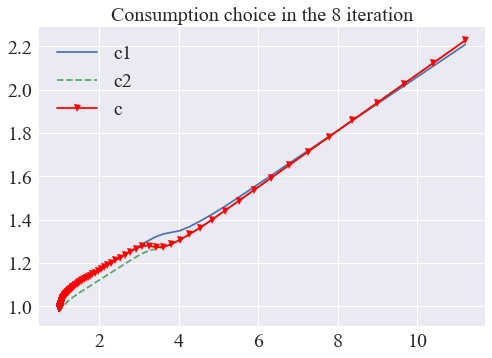

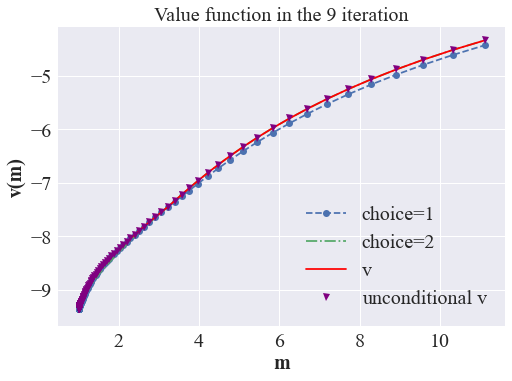

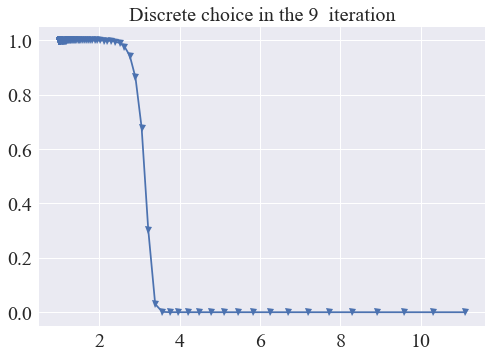

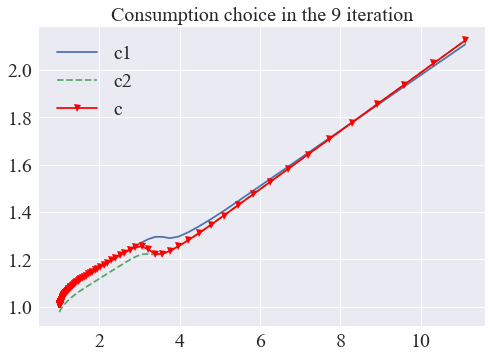

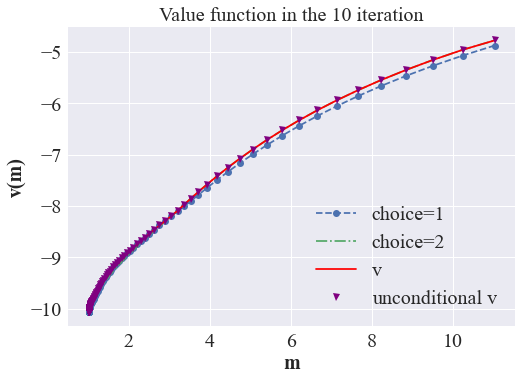

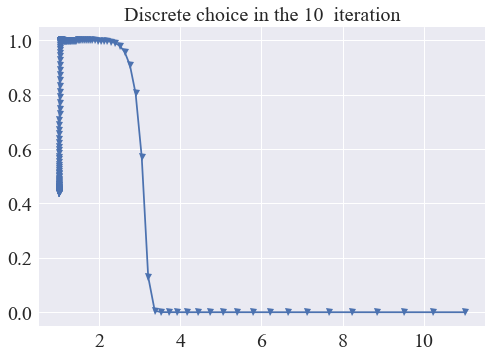

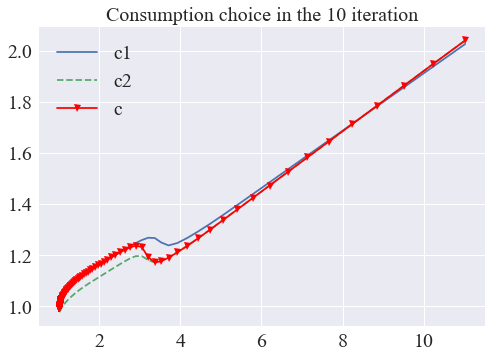

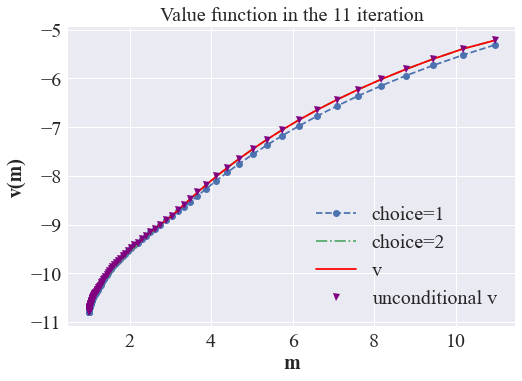

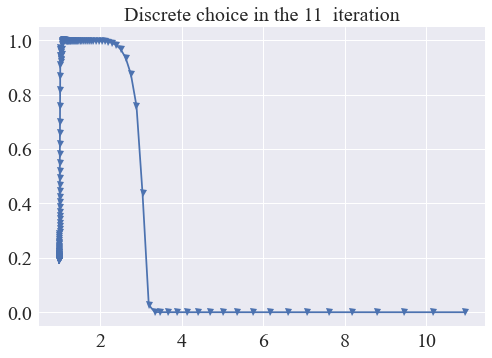

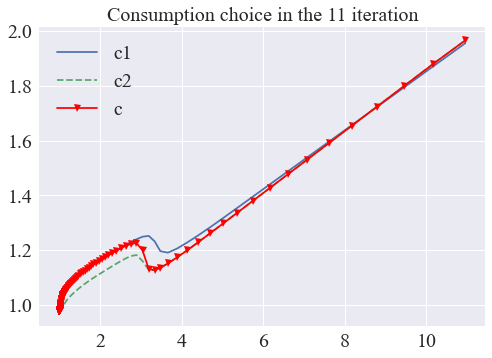

Time taken, in seconds: 56.82705116271973


In [17]:
if __name__ == "__main__":

    t_start = time()
    
    start_m_at = int(m_init.shape[0]/6)

    iter = 0

    ## terminal solution
    while iter <=10:
        m_out,σ_1_out,σ_2_out,d_out,v_1_out,v_2_out,v_out = EGM_DC(m_out,
                                                                   σ_1_out,
                                                                   σ_2_out,
                                                                   d_out,
                                                                   v_1_out,
                                                                   v_2_out,
                                                                   v_out,
                                                                   lc_dc.L-6, 
                                                                   lc_dc)
        iter+=1
        
        ## Plot the value funciton after the first iterations 
        
        plt.title('Value function in the {} iteration'.format(iter))
        plt.plot(m_out[start_m_at:-1,1,1],
                v_1_out[start_m_at:-1,1,1],
                'o--',
                label='choice=1')
        
        plt.plot(m_out[start_m_at:-1,1,1],
                v_2_out[start_m_at:-1,1,1],
                '-.',
                label='choice=2')
        plt.plot(m_out[start_m_at:-1,1,1],
                        d_out[start_m_at:-1,1,1]*v_1_out[start_m_at:-1,1,1]+(1- d_out[start_m_at:-1,1,1])*v_2_out[start_m_at:-1,1,1],
                        'r-',
                        label='v')
        plt.plot(m_out[start_m_at:-1,1,1],
                        v_out[start_m_at:-1,1,1],
                        'v',
                        color='purple',
                        label='unconditional v')
        
        plt.xlabel('m')
        plt.ylabel('v(m)')
        plt.legend()
        plt.show()

        plt.plot(m_out[start_m_at:-1,1,1],
                d_out[start_m_at:-1,1,1],
                '-v')
        plt.title('Discrete choice in the {}  iteration'.format(iter))
        plt.show()

        plt.plot(m_out[start_m_at:-1,1,1],
                σ_1_out[start_m_at:-1,1,1],
                '-',label='c1')
        plt.plot(m_out[start_m_at:-1,1,1],
                σ_2_out[start_m_at:-1,1,1],
                '--',label='c2')
        plt.plot(m_out[start_m_at:-1,1,1],
                d_out[start_m_at:-1,1,1]*σ_1_out[start_m_at:-1,1,1]+(1- d_out[start_m_at:-1,1,1])*σ_2_out[start_m_at:-1,1,1],
                'r-v',label='c')
        
        plt.legend()
        plt.title('Consumption choice in the {} iteration'.format(iter))
        plt.show()

t_finish = time()
print("Time taken, in seconds: "+ str(t_finish - t_start))


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_18238/739979001.py:23: RuntimeWarning: divide by zero encountered in log
  y_func_interp = lambda x,z: np.log(y_funcT_interp(x,z))


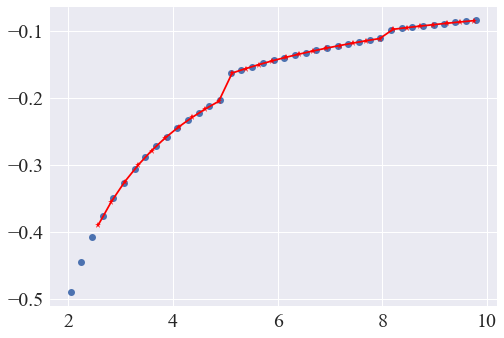

In [18]:
## Tests for the interpolation function

# Defining the function as described
def f(x):
    if x < 5:
        return lc_dc.u(x)
    elif x < 8:
        return lc_dc.u(x+1)
    else:
        return lc_dc.u(x+2)
    
# Creating an array of 60 grid points between 0 and 10
x_values = np.linspace(0, 10, 50)

# Evaluating the function at each grid point
y_values = np.array([f(x) for x in x_values])
y_values_2d = np.tile(y_values,(2,1)).T
z_values = np.array([0.0,1.0])

## use multi-dimensional interpolation function to interpolate the 2d array
## at the grid points of x_values and z_Values 
y_funcT_interp = lambda x,z: mlinterp((x_values,z_values),np.exp(y_values_2d), (x,z))
y_func_interp = lambda x,z: np.log(y_funcT_interp(x,z))

x_values_plots = np.linspace(0,10,40)
y_values_plots = np.array([y_func_interp(x,0.0) for x in x_values_plots])

## plot both the original function and the interpolated function
plt.plot(x_values[10:-1], 
         y_values[10:-1], 
         'o', 
         label='Original function')
plt.plot(x_values_plots[10:-1], 
         y_values_plots[10:-1], 
         'r*-', 
         label='Interpolated function')

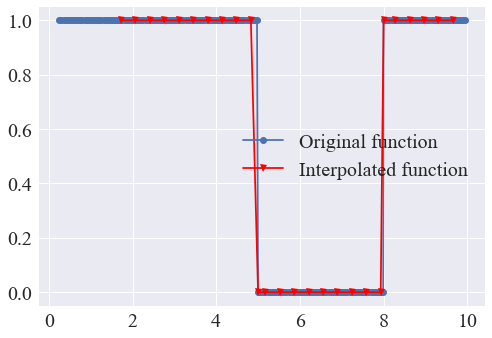

In [19]:
## Tests for the interpolation function

# Defining the function as described
def f(x):
    if x < 5:
        return 1.0
    elif x < 8:
        return 0.0
    else:
        return 1.0
    
# Creating an array of 60 grid points between 0 and 10
x_values = np.linspace(0, 10, 200)
#add 5, 8 to the x_values and sort them
x_values = np.sort(np.concatenate((x_values,[5,8])))
# Evaluating the function at each grid point
y_values = np.array([f(x) for x in x_values])
y_values_2d = np.tile(y_values,(2,1)).T
z_values = np.array([0.0,1.0])

## use multi-dimensional interpolation function to interpolate the 2d array
## at the grid points of x_values and z_Values 
y_funcT_interp = lambda x,z: mlinterp((x_values,z_values),y_values_2d, (x,z))
y_func_interp = lambda x,z: y_funcT_interp(x,z)

x_values_plots = np.linspace(0,10,30)
x_values_plots = np.sort(np.concatenate((x_values_plots,[5,8])))
y_values_plots = np.array([y_func_interp(x,0.0) for x in x_values_plots])

## plot both the original function and the interpolated function
plt.plot(x_values[5:-1], 
         y_values[5:-1], 
         '-o', 
         label='Original function')
plt.plot(x_values_plots[5:-1], 
         y_values_plots[5:-1], 
         'rv-', 
         label='Interpolated function')

plt.legend()

In [20]:
if __name__ == "__main__":

    t_start = time()

    ### this line is very important!!!!
    #### need to regenerate shock draws for new sigmas
    lc_dc.prepare_shocks()

    ## terminal solution
    m_init,σ_1_init,σ_2_init,d_init,v_1_init,v_2_init, v_init= lc_dc.terminal_solution()
            
    ## solve backward
    ms_star, σs_1_star,σs_2_star, ds_star, vs_1_star,vs_2_star,vs_star = solve_model_backward_iter_DC(lc_dc,
                                                                                                m_init,
                                                                                                σ_1_init,
                                                                                                σ_2_init,
                                                                                                d_init,
                                                                                                v_1_init,
                                                                                                v_2_init,
                                                                                                v_init)                         
    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2
at work age of 1
Time taken, in seconds: 149.1796669960022


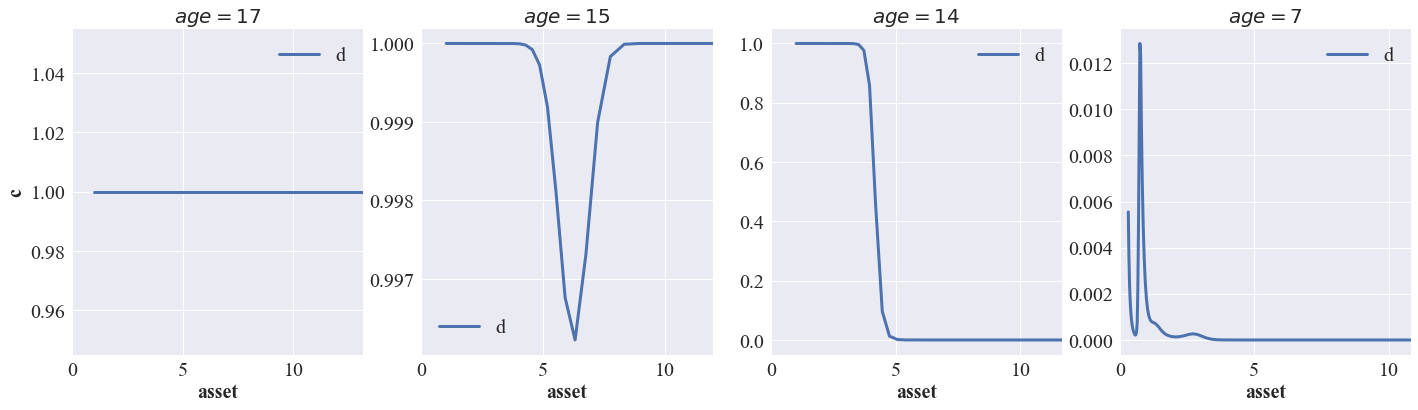

In [21]:
if __name__ == "__main__":

    ## plot c func at different age /asset grid
    years_left = [3,5,6,13]
    
    start_m_at = int(m_init.shape[0]/6)
    n_sub = len(years_left)

    eps_fix = 0 ## the first eps grid 

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_dc.L-year
        i = lc_dc.L-age
        m_plt,d_plt = ms_star[i,start_m_at:-1,eps_fix,0],ds_star[i,start_m_at:-1,eps_fix,0]
        axes[x].plot(m_plt,
                        d_plt,
                        lw=3,
                        label='d'
                    )

        axes[x].legend()
        axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'$age={}$'.format(age))

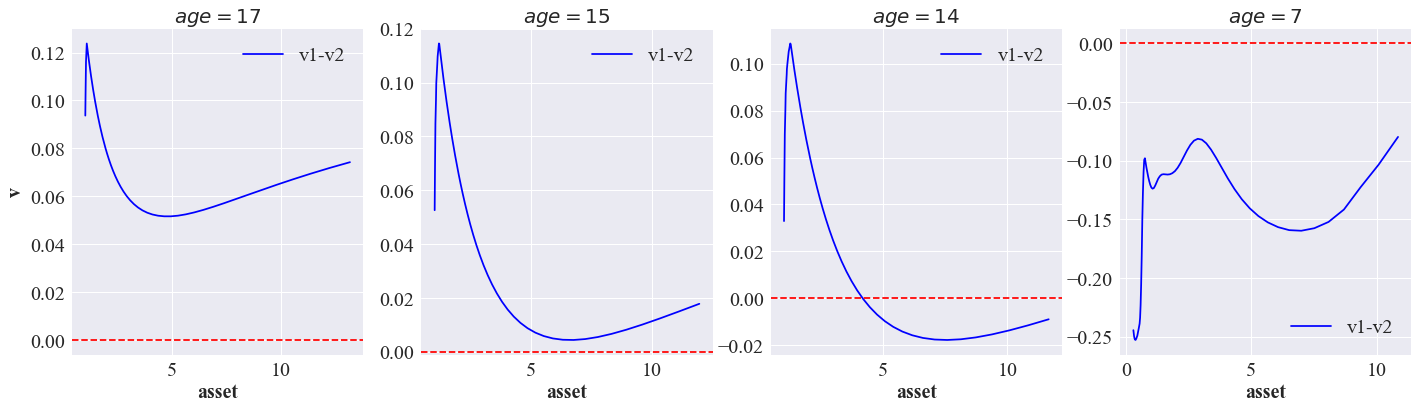

In [22]:
if __name__ == "__main__":

    ## plot c func at different age /asset grid
    
    n_sub = len(years_left)
    start_m_at = 2
    
    eps_fix = 0 ## the first eps grid 

    fig,axes = plt.subplots(1,n_sub,
                            figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_dc.L-year
        i = lc_dc.L-age
        m_plt,v1_plt,v2_plt = ms_star[i,start_m_at:-1,eps_fix,1],vs_1_star[i,start_m_at:-1,eps_fix,1],vs_2_star[i,start_m_at:-1,eps_fix,1]
        axes[x].plot(m_plt,
                    v1_plt-v2_plt,
                    'b-',
                    label='v1-v2'
                    )
        axes[x].axhline(y=0.0, 
                        color='r', linestyle='--')
        axes[x].legend()
        #axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('v')
        axes[x].set_title(r'$age={}$'.format(age))

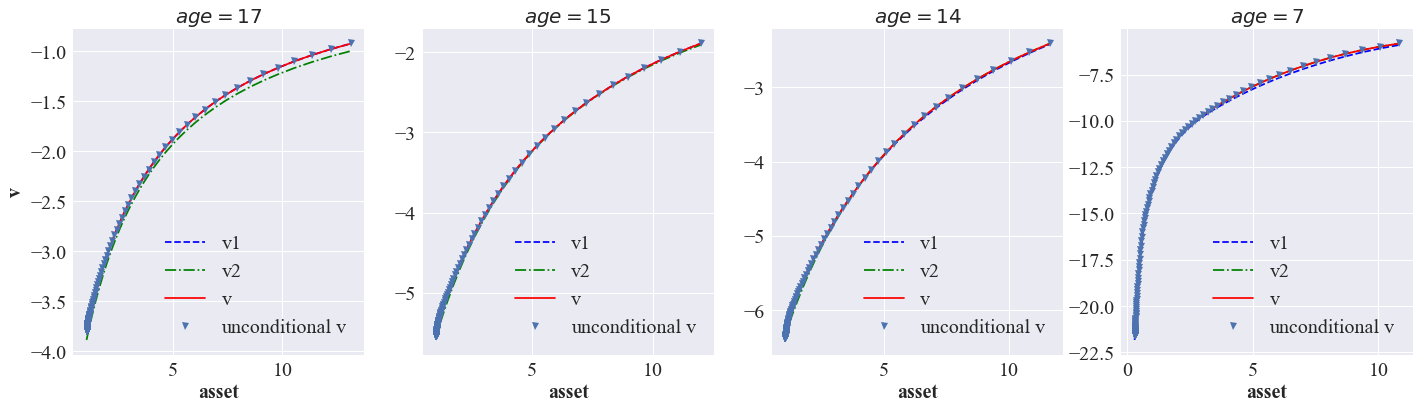

In [23]:
if __name__ == "__main__":

    ## plot c func at different age /asset grid
    
    n_sub = len(years_left)

    eps_fix = 0 ## the first eps grid 

    fig,axes = plt.subplots(1,n_sub,
                            figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_dc.L-year
        i = lc_dc.L-age
        m_plt,v1_plt,v2_plt,d_plot,v_plot = ms_star[i,start_m_at:-1,eps_fix,1],vs_1_star[i,start_m_at:-1,eps_fix,1],vs_2_star[i,start_m_at:-1,eps_fix,1],ds_star[i,start_m_at:-1,eps_fix,1],vs_star[i,start_m_at:-1,eps_fix,1]
        axes[x].plot(m_plt,
                    v1_plt,
                    'b--',
                    label='v1'
                    )
        axes[x].plot(m_plt,
                    v2_plt,
                     'g-.',
                    label='v2')
        axes[x].plot(m_plt,
                     d_plot*v1_plt+(1-d_plot)*v2_plt,
                    'r-',
                    label='v')
        axes[x].plot(m_plt,
                     v_plot,
                    'v',
                    label='unconditional v')
        axes[x].legend()
        #axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('v')
        axes[x].set_title(r'$age={}$'.format(age))

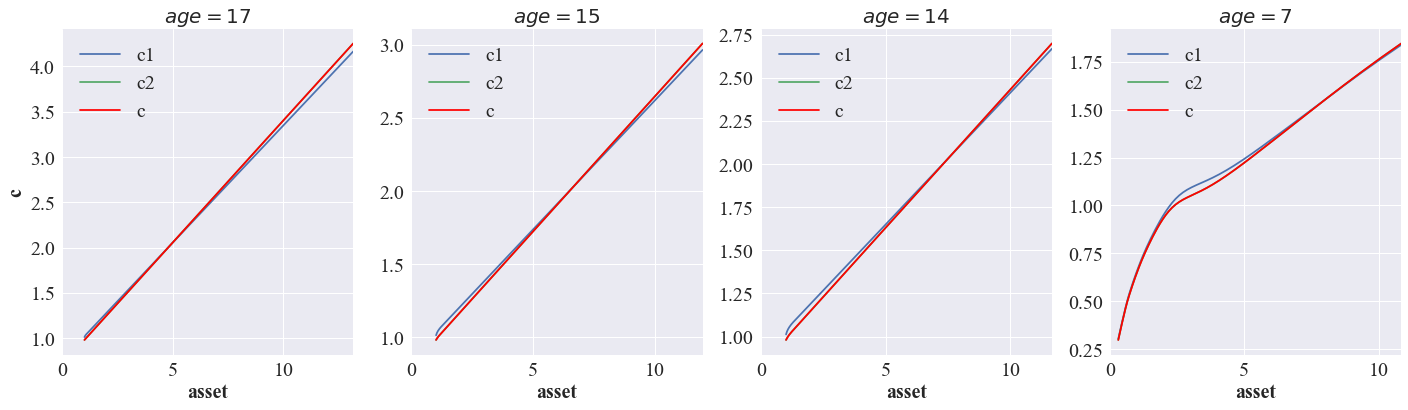

In [24]:
if __name__ == "__main__":

    ## plot c func at different age /asset grid
    
    n_sub = len(years_left)

    eps_fix = 0 ## the first eps grid 

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_dc.L-year
        i = lc_dc.L-age
        m_plt,c1_plt,c2_plt, d_plt = ms_star[i,start_m_at:-1,eps_fix,0],σs_1_star[i,start_m_at:-1,eps_fix,0],σs_2_star[i,start_m_at:-1,eps_fix,0],ds_star[i,start_m_at:-1,eps_fix,0]
        axes[x].plot(m_plt,
                        c1_plt,
                        label='c1'
                    )
        axes[x].plot(m_plt,
                        c2_plt,
                    label='c2')
        
        axes[x].plot(m_plt,
                     d_plot*c1_plt+(1-d_plot)*c2_plt,
                    'r-',
                    label='c')
        
        axes[x].legend()
        axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'$age={}$'.format(age))

## Infinite horizon problem

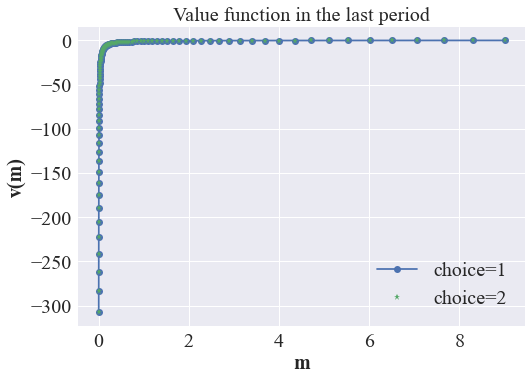

In [25]:
if __name__ == "__main__":
    
    inf_liv_paras = copy(lc_paras)
    
    ## initialize a model instance

    inf_liv = LifeCycleDC(**inf_liv_paras)

    ## initial guess of consumption functions 

    m_init,σ_1_init,σ_2_init,d_init,v_1_init,v_2_init, v_init = inf_liv.terminal_solution()
   
    plt.title('Value function in the last period')
    plt.plot(m_init[int(m_init.shape[0]/2):-1,1,1],
             v_1_init[int(m_init.shape[0]/2):-1,1,1],
            'o-',label='choice=1')
    
    plt.plot(m_init[int(m_init.shape[0]/2):-1,1,1],
             v_2_init[int(m_init.shape[0]/2):-1,1,1],
            '*',label='choice=2')
    
    plt.xlabel('m')
    plt.ylabel('v(m)')
    plt.legend()

Error at iteration 50 is 0.3500910007528404.
Error at iteration 100 is 1.4682252033251615.
Error at iteration 150 is 0.09495134557312213.
Error at iteration 200 is 0.0019799521264189934.
Error at iteration 250 is 4.2627440450360155e-05.

Converged in 299 iterations.
Time taken, in seconds: 3222.120327949524


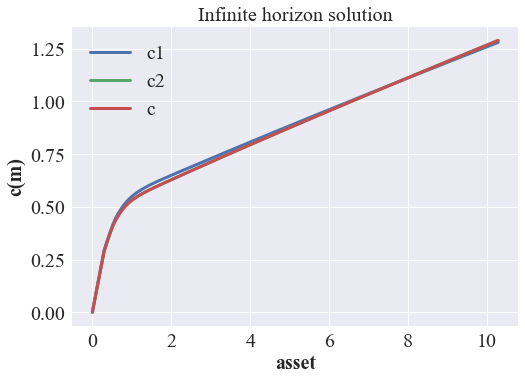

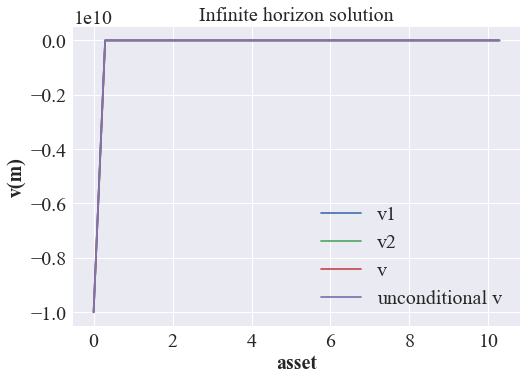

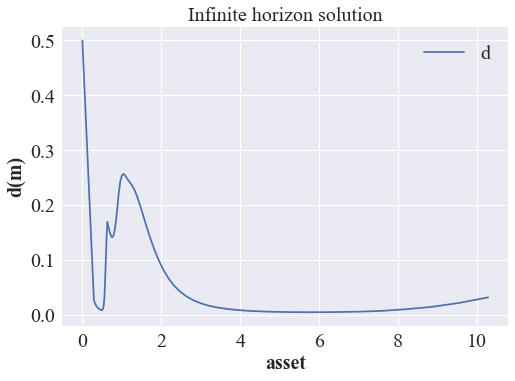

In [26]:
if __name__ == "__main__":

    t_start = time()

    ## set different ma parameters 
    m_inf_star, σ_1_inf_star,σ_2_inf_star,d_inf_star,v_1_inf_star,v_2_inf_star, v_inf_star = solve_model_iter_DC(inf_liv,
                                                                                                                m_init,
                                                                                                                σ_1_init,
                                                                                                                σ_2_init,
                                                                                                                d_init,
                                                                                                                v_1_init,
                                                                                                                v_2_init,
                                                                                                                v_init)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   

    ## plot c func 
    plt.plot(m_inf_star[0:-1,0,0],
             σ_1_inf_star[0:-1,0,0],
             lw=3,
             label='c1'
            )
    plt.plot(m_inf_star[0:-1,0,0],
             σ_2_inf_star[0:-1,0,0],
             lw=3,
             label='c2'
            )
    plt.plot(m_inf_star[0:-1,0,0],
             d_inf_star[0:-1,0,0]*σ_2_inf_star[0:-1,0,0]+(1-d_inf_star[0:-1,0,0])*σ_2_inf_star[0:-1,0,0],
             lw=3,
             label='c'
            )
    plt.legend()
    plt.xlabel('asset')
    plt.ylabel('c(m)')
    plt.title('Infinite horizon solution')
    plt.show()

    ## plot v func 

    plt.plot(m_inf_star[0:-1,0,0],
             v_1_inf_star[0:-1,0,0],
             label='v1'
            )
    plt.plot(m_inf_star[0:-1,0,0],
             v_2_inf_star[0:-1,0,0],
             label='v2'
            )
    plt.plot(m_inf_star[0:-1,0,0],
             d_inf_star[0:-1,0,0]*v_1_inf_star[0:-1,0,0]+(1-d_inf_star[0:-1,0,0])*v_2_inf_star[0:-1,0,0],
             label='v'
            )
    
    plt.plot(m_inf_star[0:-1,0,0],
             v_inf_star[0:-1,0,0],
             label='unconditional v'
            )
    plt.legend()
    plt.xlabel('asset')
    plt.ylabel('v(m)')
    plt.title('Infinite horizon solution')
    plt.show()

    # plot d func
    plt.plot(m_inf_star[0:-1,0,0],
             d_inf_star[0:-1,0,0],
             label='d'
            )
 
    plt.legend()
    plt.xlabel('asset')
    plt.ylabel('d(m)')
    plt.title('Infinite horizon solution')
    plt.show()
